### Цель проекта: на основе данных, полученных с сайтов конкурента и генерального дистрибутора, выявить закономерности ценовой политики (зависимость процента наценки от различных факторов) конкурента.  

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'svg'

In [234]:
# 1. Основные библиотеки
import pickle   # сохранение модели
import matplotlib
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [239]:
df = pd.read_csv('navigator_clear_2_2.csv')
df

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
0,3415,3415,4310-2203011-01,3347,ОАО Белкард г.Гродно Беларусь[Белкард Беларусь],Вал карданный КАМАЗ 4310-2203011 L-1140 передний,14920.0,navigator,13733.68,9
1,36883,36883,65117-2201006-20,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-20 L=2830 мм,57210.0,navigator,54474.96,5
2,18760,18760,43118-2203011-30,3350,ОАО Белкард г.Гродно Беларусь[Белкард Беларусь],Вал карданный КАМАЗ 43118-2203011-30,26230.0,navigator,24332.83,8
3,65261,65261,43114-2203011,3353,ОАО Белкард г.Гродно Беларусь[Белкард Беларусь],Вал карданный КАМАЗ 43114-2203011,26000.0,navigator,24126.24,8
4,34167,34167,65117-2201006-40,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-40 L=2710мм,58230.0,navigator,55444.89,5
...,...,...,...,...,...,...,...,...,...,...
3997,23119,23119,4552.3702,3350,АО Концерн Прамо. ELTRA[ПРАМО г. Москва],Щеткодержатель генератора КАМАЗ 4552.3702,1475.0,navigator,1342.48,10
3998,72025,72025,4502.3771.060,3353,АО Концерн Прамо. ELTRA[ПРАМО г. Москва],Щеткодержатель генератора КАМАЗ 4502.3771.060,460.0,navigator,353.88,30
3999,73705,73705,1124.5208100-04,3353,АО Концерн Прамо. ELTRA[ПРАМО г. Москва],Электродвигатель бачка омывателя 24В нового об...,290.0,navigator,263.53,10
4000,25925,25925,6540-3703050,3349,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Ящик АКБ КАМАЗ 6540-3703050,22610.0,navigator,20000.83,13


#### Описание датасета
* _id - уникальный идентификатор <br>
* artikul - код товара в БД конкурента <br>
* dzch_code - код производителя <br>
* catalog - номер раздела, содержащего данный товар <br>
* manufacturer - наименование производителя <br>
* name - наименование товара <br>
* price_sel - цена продажи конкурента <br>
* sourse - наименование конкурента <br>
* price_purch - цена закупки (у генерального дистрибьютора) <br>
* markup - процент наценки (вычисленный)  <br>

In [309]:
# приведение полей к нужному формату
df[["price_sel", "price_purch", "markup"]] = df[["price_sel", "price_purch", "markup"]].apply(pd.to_numeric)

In [310]:
df.dtypes

_id              object
artikul          object
dzch_code        object
catalog          object
manufacturer     object
name             object
price_sel       float64
sourse           object
price_purch     float64
markup            int64
dtype: object

In [322]:
df.describe()

,price_sel,price_purch,markup
count,4.002000e+03,4.002000e+03,4002.000000
mean,1.479369e+04,1.344613e+04,53.827586
std,7.045419e+04,6.686662e+04,956.378100
min,3.000000e+00,4.800000e-01,-22.000000
25%,4.850000e+02,3.754150e+02,15.000000
50%,1.972500e+03,1.529025e+03,21.000000
75%,7.121250e+03,5.790448e+03,37.000000
max,1.868460e+06,1.779142e+06,60317.000000


In [344]:
#работа с выбросами - убираем аномально большие наценки для товаров стомостью > 100
np.quantile(df['markup'], q=0.985)

189.0

In [346]:
df_clear = df[(df['markup'] > np.quantile(df['markup'], q=0.985)) & (df['price_purch'] > 100)]
df_clear

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
185,4168,4168,5320-2902624,3350,ООО НПО Ростар г.Набережные Челны[Ростар],Буфер КАМАЗ передней рессоры R5320-2902624,695.0,navigator,199.00,249
660,20178,20178,652820-8603610-02,3350,ООО Саратовдизельаппарат. г.Саратов[Саратовдиз...,Гидрозамедлитель 652820-8603610-02,4410.0,navigator,1467.64,200
1084,24574,24574,0630.501.278,3349,Euroricambi S.p.A. Италия[Еврорикамби Италия],Кольцо стопорное регулировочное 55х60x1.9 КПП ...,2430.0,navigator,459.97,428
1424,53179,53179,6522-3103079,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Шайба ступицы передней замковая 6522-3103079 П...,490.0,navigator,132.38,270
1518,73555,73555,740.60-1000106-02,3353,ООО Федерал Могул Набережные Челны[Федерал Мог...,Кольца поршневые КАМАЗ 740.60-1000106-02 (мото...,33005.0,navigator,3530.60,835
1883,3720,3720,5320-5206010,3350,ООО ТК БорАвтоСтекло. г.Бор[Стекло БАС г.Бор],Стекло КАМАЗ лобовое 5320-5206010 с солнц.защ....,3160.0,navigator,1011.38,212
1884,19782,19782,5320-5206010,3350,ООО ТК БорАвтоСтекло. г.Бор[Стекло БАС г.Бор],Стекло КАМАЗ лобовое 5320-5206010 с солнц.защ....,3080.0,navigator,1011.38,205
1885,3721,3721,5320-5206010,3350,ООО ТК БорАвтоСтекло. г.Бор[Стекло БАС г.Бор],Стекло КАМАЗ лобовое 5320-5206010,3015.0,navigator,1011.38,198
2077,71024,71024,4308-1601204,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Винт регулировочный КАМАЗ 4308-1601204,925.0,navigator,317.70,191
2087,61350,61350,1315.302.158,3353,ZF Sachs Lemfoerde Германия[ЦФ САКС Германия],Шестерня КАМАЗ КПП ZF привода промвала 1315.30...,11845.0,navigator,3490.52,239


In [330]:
# проверка на корреляцию признаков
df[['markup', 'price_purch']].corr()

,markup,price_purch
markup,1.000000,-0.009219
price_purch,-0.009219,1.000000


Прямой корреляции между ценой покупки (price_purch) и наценкой (markup) в рассматриваемом датасете нет, однако наблюдается повышенная плотность наблюдений вокруг некоторых значений.

In [319]:
#df_markup = dict(df_clear['markup'].value_counts())
df_clear['markup'].value_counts().head(15)

20    709
13    601
21    295
25    197
5     163
35    117
30    101
36     81
17     75
24     71
52     60
23     55
53     48
14     46
22     46
Name: markup, dtype: int64

In [282]:
df_clear = df[(df['markup'] > 300)]
df_clear

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
82,33995,33995,5490-8416051-10,3369,ООО НПО Ростар г.Набережные Челны[Ростар],Заглушка КАМАЗ 5490-8416051-10 левая,425.0,navigator,19.32,2100
1084,24574,24574,0630.501.278,3349,Euroricambi S.p.A. Италия[Еврорикамби Италия],Кольцо стопорное регулировочное 55х60x1.9 КПП ...,2430.0,navigator,459.97,428
1131,18253,18253,4310-1802017,3350,ОАО УралАТИ. г.Асбест[УралАТИ],Комплект прокладок КАМАЗ раздаточной коробки 4310,235.0,navigator,9.48,2379
1308,23035,23035,53205-3104045,3350,ООО НПО Ростар г.Набережные Челны[Ростар],Пробка ступицы задней Е (резина) Р53205-310404...,15.0,navigator,3.54,324
1518,73555,73555,740.60-1000106-02,3353,ООО Федерал Могул Набережные Челны[Федерал Мог...,Кольца поршневые КАМАЗ 740.60-1000106-02 (мото...,33005.0,navigator,3530.60,835
1806,81797,81797,5320-6103218,3374,ПАО Балаковорезинотехника. г.Балаково[БРТ г.Ба...,Прокладка КАМАЗ опускного стекла 5320-6103218...,255.0,navigator,25.93,883
2214,16108,16108,1346.306.088,3350,ZF Sachs Lemfoerde Германия[ЦФ САКС КАМАЗ Герм...,Болт КПП ZF КАМАЗ 1346.306.088,2105.0,navigator,404.22,421
2305,4357,4357,740-1307000,3350,ООО МПК Насос-Авто. г.Мичуринск[Насос-Авто г.М...,Ремкомплект КАМАЗ водяного насоса (4поз..4дет....,880.0,navigator,48.82,1703
2406,34211,34211,1316.301.064,3369,Euroricambi S.p.A. Италия[Еврорикамби Италия],Картер сцепления 1316.301.064 Камаз КПП ZF 16S...,54000.0,navigator,10541.77,412
2485,16289,16289,0501.330.690,3350,ZF Sachs Lemfoerde Германия[ЦФ САКС Германия],Втулка упорная 0501.330.690 КПП ZF,1890.0,navigator,282.78,568


In [290]:
#работа с выбросами - убираем аномально большие наценки
np.quantile(df['markup'], q=0.975)

143.0

In [291]:
df_clear = df[(df['markup'] > 1) & (df['markup'] < 143)]
df_clear

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
0,3415,3415,4310-2203011-01,3347,ОАО Белкард г.Гродно Беларусь[Белкард Беларусь],Вал карданный КАМАЗ 4310-2203011 L-1140 передний,14920.0,navigator,13733.68,9
1,36883,36883,65117-2201006-20,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-20 L=2830 мм,57210.0,navigator,54474.96,5
2,18760,18760,43118-2203011-30,3350,ОАО Белкард г.Гродно Беларусь[Белкард Беларусь],Вал карданный КАМАЗ 43118-2203011-30,26230.0,navigator,24332.83,8
3,65261,65261,43114-2203011,3353,ОАО Белкард г.Гродно Беларусь[Белкард Беларусь],Вал карданный КАМАЗ 43114-2203011,26000.0,navigator,24126.24,8
4,34167,34167,65117-2201006-40,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-40 L=2710мм,58230.0,navigator,55444.89,5
...,...,...,...,...,...,...,...,...,...,...
3997,23119,23119,4552.3702,3350,АО Концерн Прамо. ELTRA[ПРАМО г. Москва],Щеткодержатель генератора КАМАЗ 4552.3702,1475.0,navigator,1342.48,10
3998,72025,72025,4502.3771.060,3353,АО Концерн Прамо. ELTRA[ПРАМО г. Москва],Щеткодержатель генератора КАМАЗ 4502.3771.060,460.0,navigator,353.88,30
3999,73705,73705,1124.5208100-04,3353,АО Концерн Прамо. ELTRA[ПРАМО г. Москва],Электродвигатель бачка омывателя 24В нового об...,290.0,navigator,263.53,10
4000,25925,25925,6540-3703050,3349,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Ящик АКБ КАМАЗ 6540-3703050,22610.0,navigator,20000.83,13


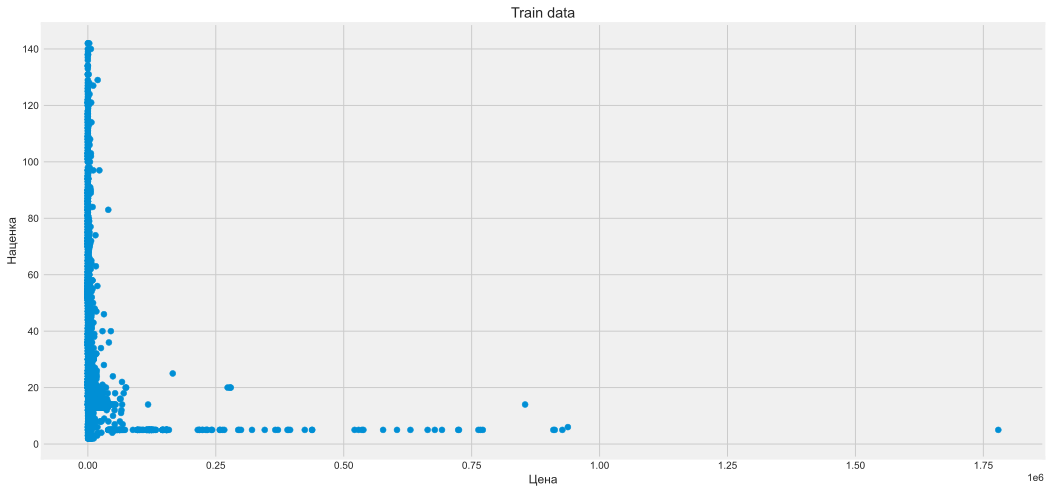

In [289]:
plt.figure(figsize = (16, 8))
plt.scatter(df_clear['price_purch'], df_clear['markup'])

plt.xlabel('Цена')
plt.ylabel('Наценка')

plt.title('Train data')

plt.show()

на графике видно, что при превышении цены некоторого значения, наценка остается на одном уровне 

In [295]:
df_markup = dict(df_clear['markup'].value_counts())
df_markup

{20: 709,
 13: 601,
 21: 295,
 25: 197,
 5: 163,
 35: 117,
 30: 101,
 36: 81,
 17: 75,
 24: 71,
 52: 60,
 23: 55,
 53: 48,
 14: 46,
 22: 46,
 15: 45,
 54: 42,
 28: 35,
 55: 33,
 16: 28,
 18: 27,
 56: 23,
 27: 23,
 6: 22,
 72: 20,
 57: 20,
 38: 19,
 73: 18,
 26: 18,
 49: 18,
 71: 18,
 29: 17,
 51: 17,
 12: 17,
 58: 17,
 31: 16,
 39: 16,
 34: 15,
 37: 15,
 19: 14,
 11: 14,
 83: 14,
 32: 14,
 9: 13,
 70: 13,
 2: 13,
 65: 13,
 7: 12,
 61: 12,
 89: 12,
 50: 12,
 33: 11,
 42: 11,
 3: 11,
 81: 11,
 90: 11,
 86: 11,
 75: 11,
 45: 11,
 63: 11,
 47: 10,
 79: 10,
 40: 10,
 94: 10,
 60: 9,
 74: 9,
 84: 9,
 48: 9,
 41: 9,
 43: 9,
 77: 9,
 121: 9,
 10: 9,
 87: 8,
 102: 8,
 59: 8,
 44: 8,
 46: 8,
 8: 8,
 88: 8,
 67: 8,
 85: 8,
 103: 8,
 101: 7,
 4: 7,
 62: 7,
 78: 7,
 68: 6,
 97: 6,
 109: 6,
 76: 6,
 66: 5,
 64: 5,
 80: 5,
 107: 5,
 115: 5,
 108: 5,
 120: 5,
 95: 5,
 114: 5,
 112: 4,
 69: 4,
 117: 4,
 131: 4,
 91: 4,
 134: 4,
 116: 3,
 138: 3,
 122: 3,
 93: 3,
 82: 3,
 113: 3,
 105: 3,
 106: 3,
 104:

Рассмотрим гипотезу, о том, что значение наценки = 5 применяется при уровне цены не менее . <br>

In [299]:
df_clear_5_percent = df_clear[(df_clear['markup'] == 5)]
df_clear.describe()

,_id,artikul,catalog,price_sel,price_purch,markup
count,3849.000000,3849.000000,3849.000000,3.849000e+03,3.849000e+03,3849.000000
mean,38158.925955,38158.925955,3351.807482,1.469752e+04,1.335928e+04,31.200052
std,25489.958438,25489.958438,64.618564,7.081093e+04,6.696233e+04,25.340878
min,1079.000000,1079.000000,2971.000000,3.000000e+00,1.310000e+00,2.000000
25%,16330.000000,16330.000000,3350.000000,5.150000e+02,4.036000e+02,15.000000
50%,34001.000000,34001.000000,3353.000000,2.040000e+03,1.583980e+03,21.000000
75%,64651.000000,64651.000000,3369.000000,7.005000e+03,5.847230e+03,36.000000
max,82204.000000,82204.000000,3567.000000,1.868460e+06,1.779142e+06,142.000000


In [301]:
df_markup_5 = df_clear_5_percent['price_purch'].value_counts()
df_markup_5

145762.01    4
153069.70    4
124288.46    3
261.23       3
115937.94    3
            ..
117385.30    1
217829.73    1
663996.54    1
535689.32    1
39638.01     1
Name: price_purch, Length: 139, dtype: int64

Рассмотрим гипотезу, о том, что величина наценки зависит от некоего ценового диапазона. <br>
Ведем дополнительный категориальный признак в датасет. 

Предположим, что помимо цены, величина наценки также зависит от производителя (manufacturer) и группы товаров (catalog) 

In [217]:
df.shape

(4002, 10)

In [238]:
df_Kamaz = df[(df['manufacturer'] == 'ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти]') | 
(df['manufacturer'] == 'ПАО КАМАЗ г.Набережные Челны[КАМАЗ смежники запчасти]') |
(df['manufacturer'] == 'ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти комплектация]') ]
df_Kamaz

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
1,36883,36883,65117-2201006-20,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-20 L=2830 мм,57210.0,navigator,54474.96,5
4,34167,34167,65117-2201006-40,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-40 L=2710мм,58230.0,navigator,55444.89,5
5,12461,12461,53205-2205011-10,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ основной 53205-2205011-10 ...,33650.0,navigator,29768.82,13
8,4089,4089,5320-2509049,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вилка блокировки КАМАЗ 5320-2509049,1030.0,navigator,853.55,21
9,30891,30891,4308-2201006-83,2971,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ трехшарнирный 4308-2201006...,50135.0,navigator,47735.41,5
...,...,...,...,...,...,...,...,...,...,...
3986,70184,70184,5490-3731053,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Стремянка хомута 5490-3731053,465.0,navigator,383.89,21
3987,32169,32169,6520-3703162-13,3374,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Стенка торцевая ящика АКБ КАМАЗ 6520-3703162-13,600.0,navigator,497.31,21
3990,39940,39940,741.3726,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ смежники за...,Указатель поворота Камаз Е боковой 741.3726 на...,475.0,navigator,351.48,35
4000,25925,25925,6540-3703050,3349,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Ящик АКБ КАМАЗ 6540-3703050,22610.0,navigator,20000.83,13


In [240]:
df_markup = dict(df_Kamaz['markup'].value_counts())
df_markup

{20: 674,
 13: 577,
 21: 276,
 5: 155,
 25: 143,
 30: 89,
 35: 63,
 36: 55,
 52: 54,
 53: 45,
 54: 36,
 55: 25,
 22: 25,
 28: 23,
 72: 16,
 29: 14,
 56: 13,
 24: 12,
 71: 11,
 14: 11,
 73: 10,
 70: 10,
 83: 9,
 58: 9,
 27: 9,
 81: 9,
 38: 8,
 37: 8,
 6: 8,
 16: 8,
 65: 7,
 86: 7,
 51: 6,
 79: 6,
 89: 6,
 57: 6,
 75: 6,
 87: 5,
 31: 4,
 23: 4,
 84: 4,
 95: 4,
 90: 4,
 12: 4,
 32: 4,
 94: 4,
 42: 4,
 77: 4,
 88: 3,
 11: 3,
 114: 3,
 74: 3,
 34: 3,
 78: 3,
 18: 3,
 43: 3,
 85: 3,
 8: 3,
 76: 3,
 4: 3,
 26: 3,
 80: 2,
 131: 2,
 123: 2,
 96: 2,
 103: 2,
 104: 2,
 106: 2,
 62: 2,
 60: 2,
 113: 2,
 116: 2,
 120: 2,
 117: 2,
 33: 2,
 101: 2,
 19: 2,
 17: 2,
 97: 2,
 40: 2,
 93: 2,
 91: 2,
 7: 2,
 45: 2,
 63: 2,
 59: 2,
 49: 2,
 47: 2,
 10: 1,
 -4: 1,
 -6: 1,
 68: 1,
 50: 1,
 64: 1,
 44: 1,
 -18: 1,
 46: 1,
 451: 1,
 270: 1,
 82: 1,
 119: 1,
 15: 1,
 39: 1,
 61: 1,
 67: 1,
 69: 1,
 105: 1,
 107: 1,
 127: 1,
 92: 1,
 129: 1,
 133: 1,
 147: 1,
 163: 1,
 177: 1,
 191: 1,
 215: 1,
 -11: 1,
 9: 1,
 

In [278]:
df_markup = df_Kamaz['markup'].value_counts()
df_markup

 20     674
 13     577
 21     276
 5      155
 25     143
       ... 
 224      1
 232      1
 262      1
 391      1
-2        1
Name: markup, Length: 137, dtype: int64

In [221]:
df['markup'].value_counts(30)

20      0.177161
13      0.150175
21      0.073713
25      0.049225
5       0.040730
          ...   
306     0.000250
300     0.000250
270     0.000250
262     0.000250
1014    0.000250
Name: markup, Length: 239, dtype: float64

In [243]:
df_Kamaz_20 = df_Kamaz[(df_Kamaz['markup'] == 20)]
df_Kamaz_20

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
12,16048,16048,53205-2205023-20,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вилка-фланец КАМАЗ 53205-2205023-20 под кресто...,3930.0,navigator,3269.54,20
13,7936,7936,4310-2304096,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Кольцо Камаз-4310 уплотн.4310-2304096,495.0,navigator,411.64,20
16,37513,37513,65117-2202097-40,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Кронштейн КАМАЗ подвесного кардана 65117-22020...,1975.0,navigator,1643.03,20
18,68224,68224,4325-2202062,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Пластина промопоры 4325-2202062 КАМАЗ,605.0,navigator,503.03,20
19,78533,78533,43118-2202016-32,3374,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Переходник раздаточной коробки КАМАЗ 43118-220...,3435.0,navigator,2856.15,20
...,...,...,...,...,...,...,...,...,...,...
3950,33957,33957,5490-5001453,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Трубка с фитингом КАМАЗ 5490 5490-5001453,1795.0,navigator,1493.30,20
3953,33958,33958,5490-5001463,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Трубка с фитингом КАМАЗ 5490 5490-5001463,2450.0,navigator,2035.71,20
3974,27331,27331,5490-3506421,3371,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Штуцер фланцевый 5490-3506421 Камаз,1710.0,navigator,1422.29,20
3978,7208,7208,6520-3501030,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Щиток заднего тормоза Е 6520-3501030,875.0,navigator,728.07,20


In [245]:
df_Kamaz_20['catalog'].value_counts()

3350    239
3353    171
3369    115
3374     55
3349     28
3371     26
3347     17
2971     14
3567      8
3563      1
Name: catalog, dtype: int64

In [249]:
df_Kamaz_3350 = df_Kamaz[(df_Kamaz['catalog'] == 3350)]
df_Kamaz_3350

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
5,12461,12461,53205-2205011-10,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ основной 53205-2205011-10 ...,33650.0,navigator,29768.82,13
8,4089,4089,5320-2509049,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вилка блокировки КАМАЗ 5320-2509049,1030.0,navigator,853.55,21
12,16048,16048,53205-2205023-20,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вилка-фланец КАМАЗ 53205-2205023-20 под кресто...,3930.0,navigator,3269.54,20
13,7936,7936,4310-2304096,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Кольцо Камаз-4310 уплотн.4310-2304096,495.0,navigator,411.64,20
20,17494,17494,4325-2202084,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Обойма подшипника промопоры КАМАЗ 4325-2202084,2255.0,navigator,1876.80,20
...,...,...,...,...,...,...,...,...,...,...
3945,6151,6151,53205-3506041,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Трубка КАМАЗ ресивера 53205-3506041,100.0,navigator,55.97,79
3947,6102,6102,43501-4071300-24,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ смежники за...,Пучок проводов системы управления двигателем 4...,20895.0,navigator,5772.44,262
3978,7208,7208,6520-3501030,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Щиток заднего тормоза Е 6520-3501030,875.0,navigator,728.07,20
3979,13964,13964,53212-3501030-10,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Щиток заднего тормоза Е 53212-3501030-10,1295.0,navigator,1073.87,21


In [274]:
df_Kamaz_3350_100000 = df_Kamaz[(df_Kamaz['price_purch'] > 50000)]
df_Kamaz_3350_100000

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
1,36883,36883,65117-2201006-20,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-20 L=2830 мм,57210.0,navigator,54474.96,5
4,34167,34167,65117-2201006-40,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-40 L=2710мм,58230.0,navigator,55444.89,5
28,56300,56300,65117-2201006-30,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-30 L=2724 мм,54200.0,navigator,51606.77,5
75,3408,3408,5410-2702010-01,3347,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Седельное устройство КАМАЗ 5410-2702010-01,101285.0,navigator,96442.67,5
95,68440,68440,6460-2702090-10,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Подставка седельного устройства КАМАЗ 6460-270...,82730.0,navigator,70108.05,18
...,...,...,...,...,...,...,...,...,...,...
3262,56756,56756,5320-5100010,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Пол КАМАЗ 5320-5100010 в сборе,106205.0,navigator,101127.74,5
3319,29841,29841,5490-3724760-14,2971,ПАО КАМАЗ г.Набережные Челны[КАМАЗ смежники за...,Пучок 5490-3724760-14 проводов мультиплексного...,57835.0,navigator,50729.23,14
3597,7121,7121,740.21-1002012,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти ко...,Блок цилиндров КАМАЗ 740.21-1002012,255065.0,navigator,242871.07,5
3601,38320,38320,5490-3422008-15,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ рулевой 5490-3422008-15,53825.0,navigator,51248.03,5


In [276]:
df_Kamaz_3350_100000['markup'].value_counts()

 5     135
 14      5
 16      2
 12      2
 8       1
-7       1
 18      1
-11      1
-9       1
 6       1
-4       1
Name: markup, dtype: int64

In [277]:
df_Kamaz_3350_100000['catalog'].value_counts()

3350    52
3353    42
3369    27
3371    10
2971     5
3374     5
3349     4
3347     4
3567     2
Name: catalog, dtype: int64

In [272]:
df_Kamaz_3350_100000['markup'].value_counts()

 5     135
 14      5
 16      2
 12      2
 8       1
-7       1
 18      1
-11      1
-9       1
 6       1
-4       1
Name: markup, dtype: int64

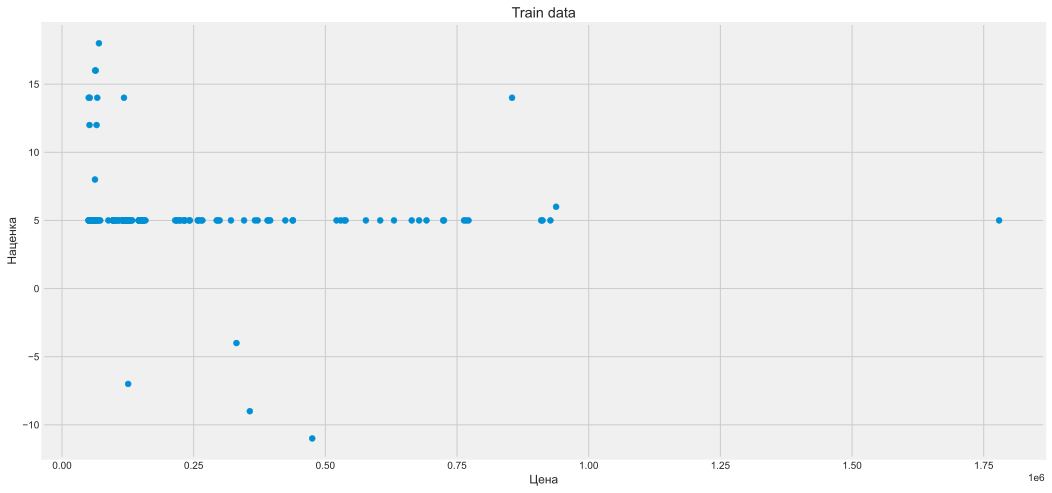

In [273]:
plt.figure(figsize = (16, 8))
plt.scatter(df_Kamaz_3350_100000['price_purch'], df_Kamaz_3350_100000['markup'])

plt.xlabel('Цена')
plt.ylabel('Наценка')

plt.title('Train data')

plt.show()

In [ ]:
df_Kamaz_20

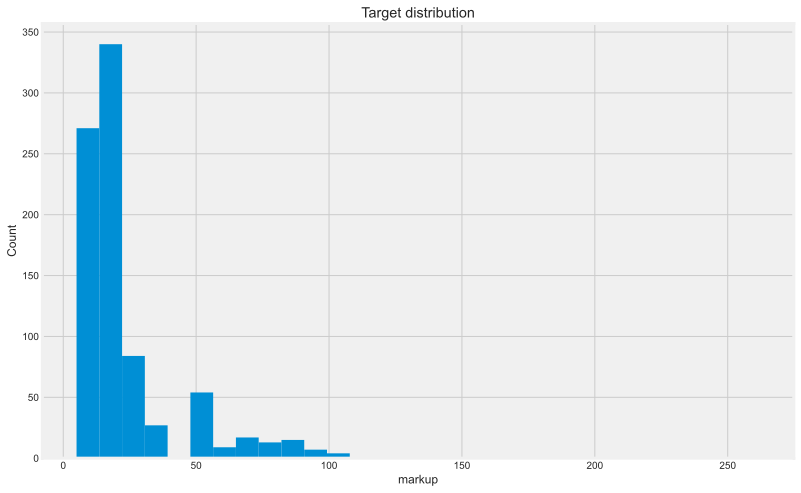

In [251]:
plt.figure(figsize = (12, 8))

df_Kamaz_3350['markup'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('markup')

plt.title('Target distribution')
plt.show()

In [222]:
df_5_20 = (df['markup'] < 101).value_counts()
df_5_20

True     3769
False     233
Name: markup, dtype: int64

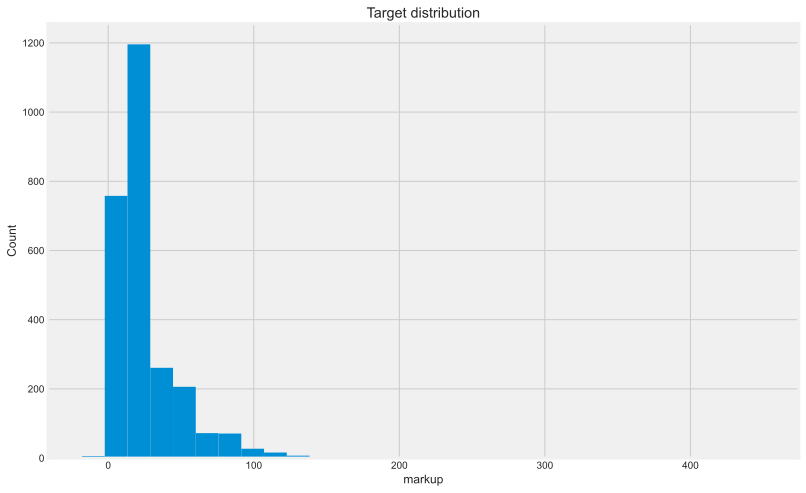

In [229]:
plt.figure(figsize = (12, 8))

df_Kamaz['markup'].hist(bins=30)
pclt.ylabel('Count')
plt.xlabel('markup')

plt.title('Target distribution')
plt.show()

In [225]:
df_markup = dict(df_Kamaz['markup'].value_counts())
df_markup

{20: 674,
 13: 577,
 21: 276,
 5: 155,
 25: 143,
 30: 89,
 35: 63,
 36: 55,
 52: 54,
 53: 45,
 54: 36,
 55: 25,
 22: 25,
 28: 23,
 72: 16,
 29: 14,
 56: 13,
 24: 12,
 71: 11,
 14: 11,
 73: 10,
 70: 10,
 83: 9,
 58: 9,
 27: 9,
 81: 9,
 38: 8,
 37: 8,
 6: 8,
 16: 8,
 65: 7,
 86: 7,
 51: 6,
 79: 6,
 89: 6,
 57: 6,
 75: 6,
 87: 5,
 31: 4,
 23: 4,
 84: 4,
 95: 4,
 90: 4,
 12: 4,
 32: 4,
 94: 4,
 42: 4,
 77: 4,
 88: 3,
 11: 3,
 114: 3,
 74: 3,
 34: 3,
 78: 3,
 18: 3,
 43: 3,
 85: 3,
 8: 3,
 76: 3,
 4: 3,
 26: 3,
 80: 2,
 131: 2,
 123: 2,
 96: 2,
 103: 2,
 104: 2,
 106: 2,
 62: 2,
 60: 2,
 113: 2,
 116: 2,
 120: 2,
 117: 2,
 33: 2,
 101: 2,
 19: 2,
 17: 2,
 97: 2,
 40: 2,
 93: 2,
 91: 2,
 7: 2,
 45: 2,
 63: 2,
 59: 2,
 49: 2,
 47: 2,
 10: 1,
 -4: 1,
 -6: 1,
 68: 1,
 50: 1,
 64: 1,
 44: 1,
 -18: 1,
 46: 1,
 451: 1,
 270: 1,
 82: 1,
 119: 1,
 15: 1,
 39: 1,
 61: 1,
 67: 1,
 69: 1,
 105: 1,
 107: 1,
 127: 1,
 92: 1,
 129: 1,
 133: 1,
 147: 1,
 163: 1,
 177: 1,
 191: 1,
 215: 1,
 -11: 1,
 9: 1,
 

In [218]:
X = df['price_purch']
Y = df['markup']

In [226]:
x = df_Kamaz['price_purch']
y = df_Kamaz['markup']

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [228]:
#df_Kamaz_100 = df_Kamaz[(df_Kamaz['markup'] < 50)  & (df_Kamaz['price_purch'] < 10000)]
df_Kamaz_100 = df_Kamaz[(df_Kamaz['markup'] < 50)  & (df_Kamaz['price_purch'] < 10000)]

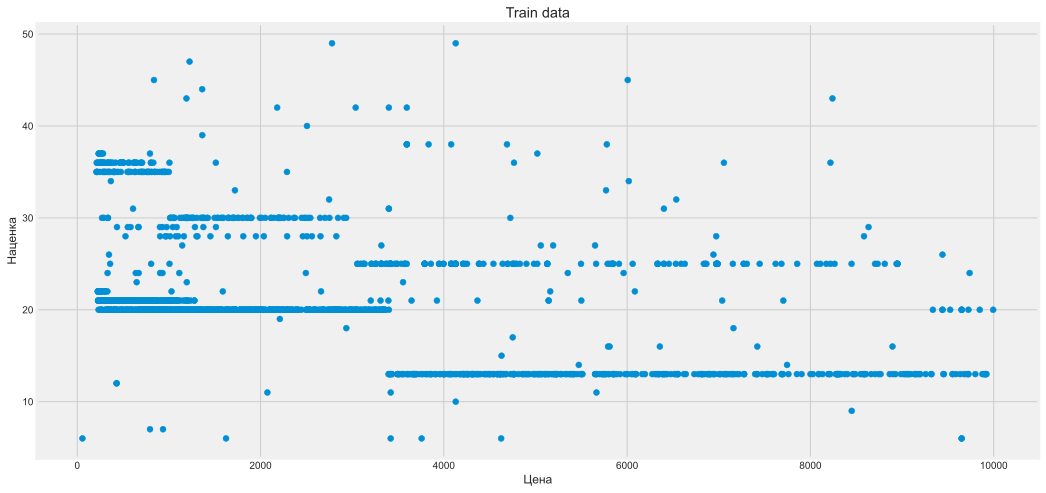

In [230]:
plt.figure(figsize = (16, 8))
plt.scatter(df_Kamaz_100['price_purch'], df_Kamaz_100['markup'])

plt.xlabel('Цена')
plt.ylabel('Наценка')

plt.title('Train data')

plt.show()

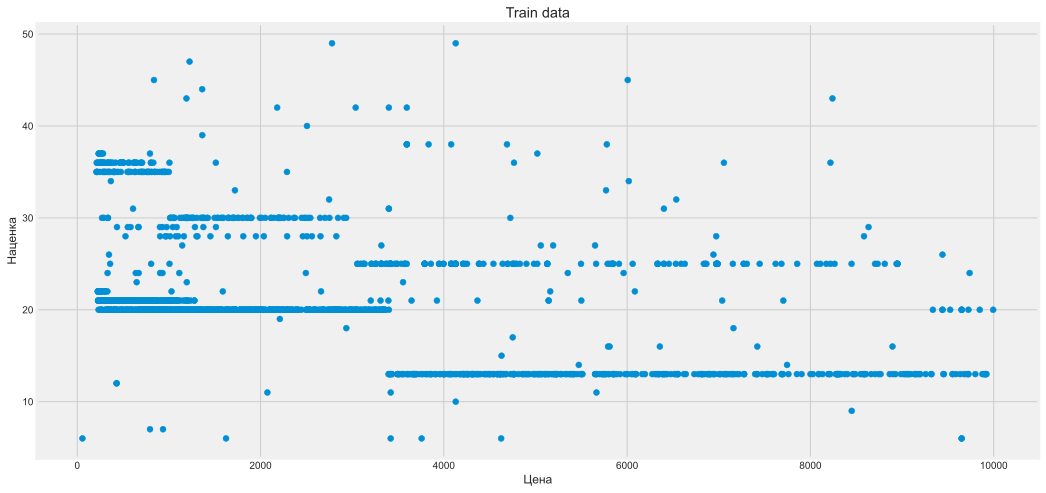

In [230]:
plt.figure(figsize = (16, 8))
plt.scatter(df_Kamaz_100['price_purch'], df_Kamaz_100['markup'])

plt.xlabel('Цена')
plt.ylabel('Наценка')

plt.title('Train data')

plt.show()

In [224]:
df_Kamaz.describe()

,_id,artikul,catalog,price_sel,price_purch,markup
count,2636.000000,2636.000000,2636.000000,2.636000e+03,2.636000e+03,2636.000000
mean,38044.536039,38044.536039,3351.701821,1.918088e+04,1.777311e+04,27.792489
std,25810.783902,25810.783902,64.697626,8.499469e+04,8.085896e+04,26.304403
min,1313.000000,1313.000000,2971.000000,7.000000e+00,3.440000e+00,-18.000000
25%,15939.500000,15939.500000,3350.000000,6.800000e+02,5.502650e+02,13.000000
50%,33950.500000,33950.500000,3353.000000,2.455000e+03,1.994630e+03,20.000000
75%,65155.500000,65155.500000,3369.000000,8.005000e+03,6.837182e+03,30.000000
max,82204.000000,82204.000000,3567.000000,1.868460e+06,1.779142e+06,451.000000


In [219]:
np.cov(X, Y)

array([[ 4.47114432e+09, -5.89527755e+05],
       [-5.89527755e+05,  9.14659070e+05]])

In [131]:
#train_df[(train_df['LifeSquare'].isna())].head()
df_Kamaz_40000 = df_Kamaz[(df_Kamaz['price_purch'] > 35001)]
df_Kamaz_40000

,_id,artikul,dzch_code,catalog,manufacturer,name,price_sel,sourse,price_purch,markup
1,36883,36883,65117-2201006-20,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-20 L=2830 мм,57210.0,navigator,54474.96,5
4,34167,34167,65117-2201006-40,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2201006-40 L=2710мм,58230.0,navigator,55444.89,5
9,30891,30891,4308-2201006-83,2971,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ трехшарнирный 4308-2201006...,50135.0,navigator,47735.41,5
10,63537,63537,65111-2202011-30,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ основной 65111-2202011-30 ...,43590.0,navigator,38564.61,13
27,64738,64738,65117-2205011-10,3353,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ 65117-2205011-10 L=1274 мм,44205.0,navigator,39106.98,13
...,...,...,...,...,...,...,...,...,...,...
3597,7121,7121,740.21-1002012,3350,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти ко...,Блок цилиндров КАМАЗ 740.21-1002012,255065.0,navigator,242871.07,5
3601,38320,38320,5490-3422008-15,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ запчасти],Вал карданный КАМАЗ рулевой 5490-3422008-15,53825.0,navigator,51248.03,5
3870,30360,30360,5490-3724760-17,2971,ПАО КАМАЗ г.Набережные Челны[КАМАЗ смежники за...,Пучок 5490-3724760-17 проводов мультиплексного...,60215.0,navigator,52818.32,14
3871,37272,37272,5490-3724760-10,3369,ПАО КАМАЗ г.Набережные Челны[КАМАЗ смежники за...,Пучок 5490-3724760-10 проводов мультиплексного...,47855.0,navigator,41977.75,14


In [126]:
df_Kamaz_40000['markup'].value_counts()

 5     153
 14      8
 16      2
 12      2
 8       2
-9       1
-7       1
 24      1
 18      1
-11      1
 6       1
 4       1
-4       1
-2       1
Name: markup, dtype: int64

In [132]:
df_Kamaz_40000['markup'].value_counts()

 5     155
 13     15
 14      8
 16      3
 12      2
 8       2
-9       1
-7       1
 24      1
 18      1
-11      1
 6       1
 4       1
-4       1
-2       1
Name: markup, dtype: int64

In [102]:
#df_Kamaz['markup'].value_counts()
df_Kamaz['markup'].sort_values().unique()

array([-18, -11,  -9,  -7,  -6,  -4,  -2,   4,   5,   6,   7,   8,   9,
        10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  42,  43,  44,  45,  46,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98, 100, 101, 103, 104, 105,
       106, 107, 108, 110, 112, 113, 114, 116, 117, 118, 119, 120, 123,
       127, 129, 131, 133, 146, 147, 148, 154, 156, 163, 177, 186, 191,
       215, 224, 232, 262, 270, 391, 451], dtype=int64)

In [113]:
df_Kamaz[['markup', 'price_purch']].corr()

,markup,price_purch
markup,1.000000,-0.166391
price_purch,-0.166391,1.000000


In [53]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

In [67]:
df_5_20 = pd.DataFrame(df['markup'] < 101)
df_5_20

,markup
0,True
1,True
2,True
3,True
4,True
...,...
3997,True
3998,True
3999,True
4000,True


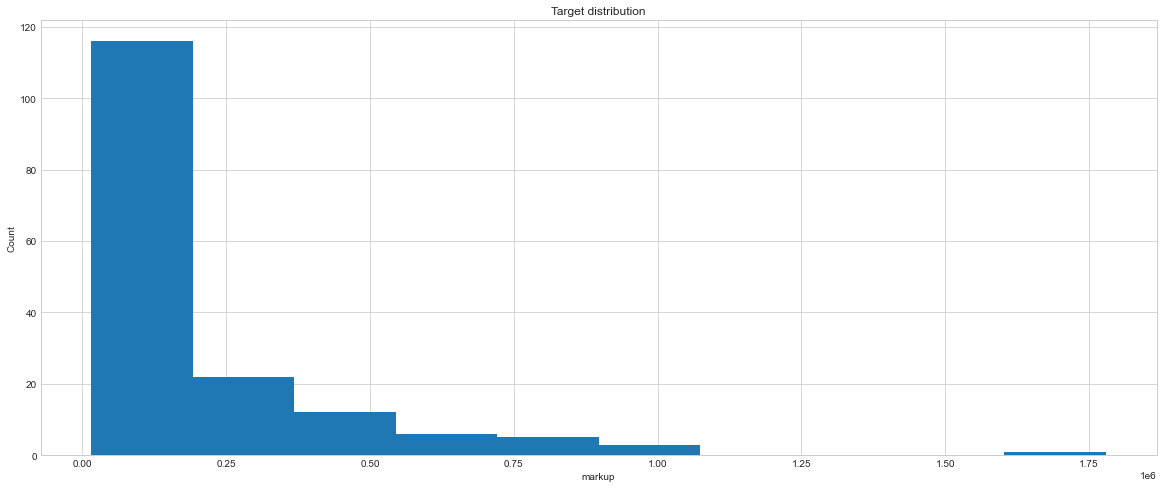

In [109]:
plt.figure(figsize = (20, 8))

df_Kamaz_5['price_purch'].hist(bins=10)
plt.ylabel('Count')
plt.xlabel('markup')

plt.title('Target distribution')
plt.show()

In [111]:
X = df_Kamaz['price_purch']
Y = df_Kamaz['markup']

In [112]:
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 markup   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              5.173
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                      0.0230
Time:                        19:51:00   Log-Likelihood:                         -13345.
No. Observations:                2636   AIC:                                  2.669e+04
Df Residuals:                    2635   BIC:                                  2.670e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [48]:
df['markup'].hist(count)

NameError: name 'count' is not defined